In [ ]:

# !pip install -q nltk scikit-learn tensorflow seaborn joblib

In [2]:
# CORE IMPORTS & CONFIG

import os
import re
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# NLP
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

# SKLEARN (Traditional ML)
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression, PassiveAggressiveClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# DEEP LEARNING
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, SimpleRNN, Bidirectional, Dense, Dropout
from tensorflow.keras.utils import to_categorical

warnings.filterwarnings("ignore")

# Seed for reproducibility
SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)
random.seed(SEED)

In [3]:
# Load dataset

df_emotion = pd.read_csv(
    'Emotion.csv',
    encoding='utf-8-sig',
    sep=';',
    on_bad_lines='skip'
)

df_emotion.head()

,id,text,emotion,lan,domain
0,2275,Hands down. You are good. I mean smart good.,joy,EN,funny_video
1,2283,Your are very good. keep it up,none,EN,funny_video
2,2292,Man!! I will never get used to these videos of...,surprise,EN,funny_video
3,2293,ডিসলাইক দেয়া 32,none,BN,funny_video
4,2298,ব্যাপক বিনোদন।,joy,BN,funny_video


In [4]:
# Check dataset structure
df_emotion.info()

# Dataset shape
df_emotion.shape

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2890 entries, 0 to 2889
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   id       2890 non-null   int64 
 1   text     2890 non-null   object
 2   emotion  2890 non-null   object
 3   lan      2890 non-null   object
 4   domain   2890 non-null   object
dtypes: int64(1), object(4)
memory usage: 113.0+ KB


(2890, 5)

In [5]:
# Language distribution
df_emotion['lan'].value_counts()

lan
RN    1137
BN    1006
EN     747
Name: count, dtype: int64

In [6]:
# check column 
df_emotion.columns.tolist()

['id', 'text', 'emotion', 'lan', 'domain']

In [7]:
# Domain distribution
df_emotion['domain'].value_counts()

domain
talkshow_video    687
music_video       440
news_video        378
drama_video       352
review_video      346
funny_video       315
sports_video      232
report_video      140
Name: count, dtype: int64

In [8]:
# Check for missing values
df_emotion.isnull().sum()

id         0
text       0
emotion    0
lan        0
domain     0
dtype: int64

In [9]:
# Duplicate check
duplicates = df_emotion.duplicated(subset='text').sum()
print("Duplicate rows:", duplicates)

Duplicate rows: 406


In [10]:
# Drop unnecessary columns and duplicates
df_emotion = df_emotion.drop(columns=['id', 'domain'], errors='ignore')
df_emotion = df_emotion.drop_duplicates().reset_index(drop=True)

print("Data cleaned. Shape after cleaning:", df_emotion.shape)


Data cleaned. Shape after cleaning: (2704, 3)


In [11]:
# TEXT PREPROCESSING 

# Download required NLTK data
nltk.download('punkt', quiet=True)
nltk.download('stopwords', quiet=True)

# STOPWORDS 
stop_en = set(stopwords.words('english'))

# Bangla stopwords
try:
    stop_bn = set(stopwords.words('bengali'))
except:
    stop_bn = set()

# Romanized Bangla stopwords
stop_rn = {
    'ami','tumi','amra','na','ta','ki','tomra','tara','ar','je','jeta','kintu','karon','ekhane','ekhono',
    'ekhon','ta','tar','tao','onek','ar','abar','korbo','korche','korlam','korte',
    'nai','hoy','hoye','ache','se','jeta','tao','tomra','tumi',
    'vai','e','kotha','u','bro','ai','ke','onek','k','eto'
}

# CLEANING FUNCTION 
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'@\w+|#\w+', ' ', text)
    text = re.sub(r'[^\u0980-\u09FFA-Za-z\s]', ' ', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# TOKENIZE + STOPWORD REMOVAL 
stemmer = PorterStemmer()

def preprocess_text(text, lang=None):
    text = clean_text(text)
    tokens = word_tokenize(text)
    lang = (lang or '').upper()

    if lang == 'BN':
        tokens = [t for t in tokens if t not in stop_bn and len(t) > 1]
    elif lang == 'EN':
        tokens = [stemmer.stem(t) for t in tokens if t not in stop_en and len(t) > 2]
    else:
        tokens = [t for t in tokens if t not in stop_rn and len(t) > 1]

    return ' '.join(tokens)

# APPLY PREPROCESSING 
df_emotion['clean_text'] = df_emotion.apply(lambda r: preprocess_text(r['text'], r['lan']), axis=1)
df_emotion = df_emotion[df_emotion['clean_text'].str.strip() != ''].reset_index(drop=True)

print(" Preprocessing complete. Shape:", df_emotion.shape)
df_emotion.head()


 Preprocessing complete. Shape: (2690, 4)


,text,emotion,lan,clean_text
0,Hands down. You are good. I mean smart good.,joy,EN,hand good mean smart good
1,Your are very good. keep it up,none,EN,good keep
2,Man!! I will never get used to these videos of...,surprise,EN,man never get use video pleas upload like
3,ডিসলাইক দেয়া 32,none,BN,ডিসলাইক দেয়া
4,ব্যাপক বিনোদন।,joy,BN,ব্যাপক বিনোদন


In [12]:
#  TRAIN TEST SPLIT

X = df_emotion['clean_text']
y = df_emotion['emotion']

le = LabelEncoder()
y_encoded = le.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)

print(" Data split done:")
print("Train size:", X_train.shape[0])
print("Test size:", X_test.shape[0])


 Data split done:
Train size: 2152
Test size: 538


In [13]:
# TF-IDF VECTORIZE

vectorizer = TfidfVectorizer(max_features=7000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

print(" TF-IDF Vectorization complete.")


 TF-IDF Vectorization complete.


In [14]:
# Logistic Regression

log_model = LogisticRegression(max_iter=200, random_state=SEED)
log_model.fit(X_train_vec, y_train)
y_pred_log = log_model.predict(X_test_vec)

 Logistic Regression Results:

Accuracy: 0.46096654275092935
              precision    recall  f1-score   support

       anger       0.29      0.12      0.17        66
     disgust       0.33      0.34      0.33       119
        fear       0.00      0.00      0.00         2
         joy       0.58      0.72      0.64       151
        none       0.45      0.63      0.53       145
      others       0.00      0.00      0.00         2
         sad       0.00      0.00      0.00        25
    surprise       0.00      0.00      0.00        28

    accuracy                           0.46       538
   macro avg       0.21      0.23      0.21       538
weighted avg       0.39      0.46      0.42       538



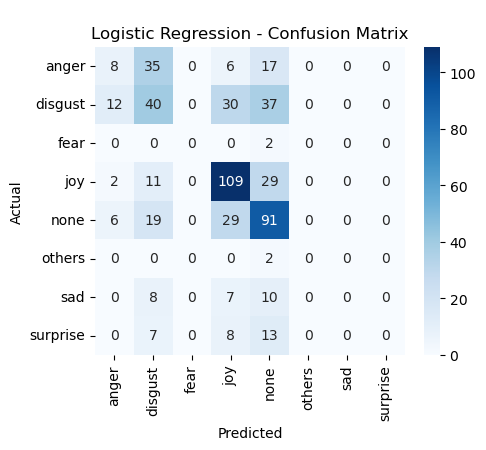

In [15]:
# Evaluate
print(" Logistic Regression Results:")
print("\nAccuracy:", accuracy_score(y_test, y_pred_log))

print(classification_report(y_test, y_pred_log, target_names=le.classes_))

# Confusion Matrix
plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_log), annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("\nLogistic Regression - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

In [16]:
# Naive Bayes

nb_model = MultinomialNB()
nb_model.fit(X_train_vec, y_train)
y_pred_nb = nb_model.predict(X_test_vec)

 Naive Bayes Results:

Accuracy: 0.44981412639405205
              precision    recall  f1-score   support

       anger       0.43      0.05      0.08        66
     disgust       0.33      0.41      0.37       119
        fear       0.00      0.00      0.00         2
         joy       0.47      0.81      0.60       151
        none       0.54      0.46      0.50       145
      others       0.00      0.00      0.00         2
         sad       0.00      0.00      0.00        25
    surprise       0.00      0.00      0.00        28

    accuracy                           0.45       538
   macro avg       0.22      0.22      0.19       538
weighted avg       0.40      0.45      0.39       538



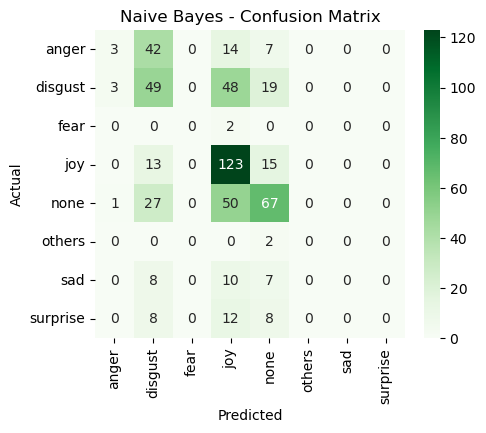

In [17]:
print(" Naive Bayes Results:")
print("\nAccuracy:", accuracy_score(y_test, y_pred_nb))

print(classification_report(y_test, y_pred_nb, target_names=le.classes_))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_nb), annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Naive Bayes - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [18]:
# Passive Aggressive 
pac_model = PassiveAggressiveClassifier(max_iter=1000, random_state=42)
pac_model.fit(X_train_vec, y_train)
y_pred_pac = pac_model.predict(X_test_vec)

 Passive Aggressive Results:

Accuracy: 0.40148698884758366
              precision    recall  f1-score   support

       anger       0.30      0.27      0.28        66
     disgust       0.24      0.22      0.23       119
        fear       0.00      0.00      0.00         2
         joy       0.59      0.62      0.60       151
        none       0.47      0.52      0.50       145
      others       0.00      0.00      0.00         2
         sad       0.04      0.04      0.04        25
    surprise       0.09      0.07      0.08        28

    accuracy                           0.40       538
   macro avg       0.22      0.22      0.22       538
weighted avg       0.39      0.40      0.39       538



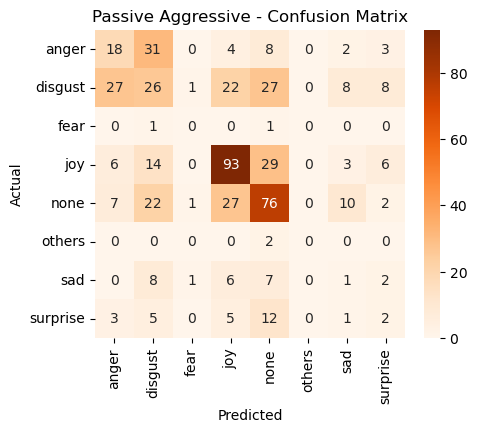

In [19]:
print(" Passive Aggressive Results:")
print("\nAccuracy:", accuracy_score(y_test, y_pred_pac))
print(classification_report(y_test, y_pred_pac, target_names=le.classes_))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_pac), annot=True, fmt='d', cmap='Oranges',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Passive Aggressive - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


In [20]:
# Linear SVM
svm_model = LinearSVC(random_state=42)
svm_model.fit(X_train_vec, y_train)
y_pred_svm = svm_model.predict(X_test_vec)

Linear SVM Results:

Accuracy: 0.43866171003717475
              precision    recall  f1-score   support

       anger       0.29      0.26      0.27        66
     disgust       0.29      0.29      0.29       119
        fear       0.00      0.00      0.00         2
         joy       0.60      0.66      0.63       151
        none       0.51      0.59      0.54       145
      others       0.00      0.00      0.00         2
         sad       0.00      0.00      0.00        25
    surprise       0.06      0.04      0.05        28

    accuracy                           0.44       538
   macro avg       0.22      0.23      0.22       538
weighted avg       0.41      0.44      0.42       538



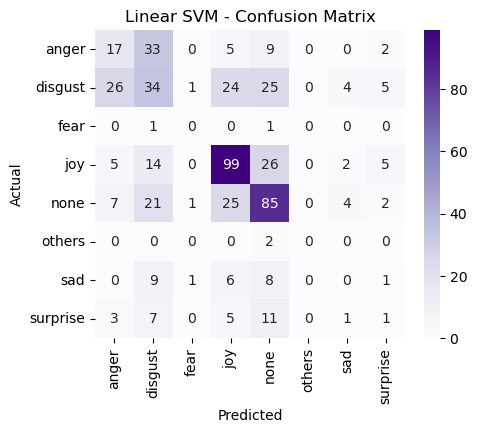

In [21]:
print("Linear SVM Results:")
print("\nAccuracy:", accuracy_score(y_test, y_pred_svm))

print(classification_report(y_test, y_pred_svm, target_names=le.classes_))

plt.figure(figsize=(5,4))
sns.heatmap(confusion_matrix(y_test, y_pred_svm), annot=True, fmt='d', cmap='Purples',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Linear SVM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


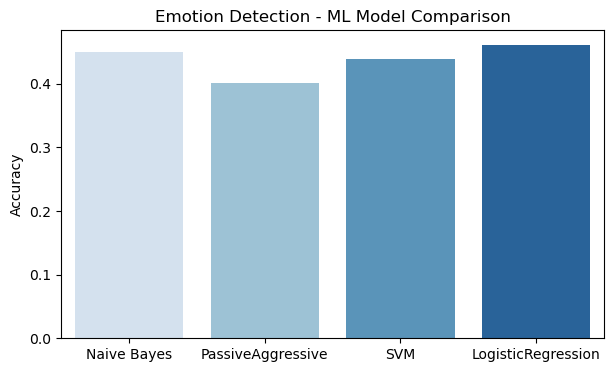

In [22]:
acc_ml = [
    accuracy_score(y_test, y_pred_nb),
    accuracy_score(y_test, y_pred_pac),
    accuracy_score(y_test, y_pred_svm),
    accuracy_score(y_test, y_pred_log)
]
models_ml = ['Naive Bayes', 'PassiveAggressive', 'SVM', 'LogisticRegression']

plt.figure(figsize=(7,4))
sns.barplot(x=models_ml, y=acc_ml, palette='Blues')
plt.title('Emotion Detection - ML Model Comparison')
plt.ylabel('Accuracy')
plt.show()


In [23]:
# Deep Learning Prep 
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# Config
MAX_VOCAB   = 7000
MAX_LEN     = 120
EPOCHS_DL   = 10
BATCH_SIZE  = 64
SEED        = 42

# Tokenizer
tokenizer = Tokenizer(num_words=MAX_VOCAB, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq  = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(
    X_train_seq,
    maxlen=MAX_LEN,
    padding='post',
    truncating='post'
)
X_test_pad = pad_sequences(
    X_test_seq,
    maxlen=MAX_LEN,
    padding='post',
    truncating='post'
)

# One-hot encode labels
num_classes = len(np.unique(y_encoded))
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat  = to_categorical(y_test,  num_classes=num_classes)

print("Tokenization & Padding complete.")
print("Train shape:", X_train_pad.shape)
print("Test shape:",  X_test_pad.shape)

# Shared callbacks for all DL models
early_stop_emo = EarlyStopping(
    monitor="val_loss",
    patience=4,
    mode="min",
    restore_best_weights=True,
    verbose=0
)

reduce_lr_emo = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.3,
    patience=2,
    min_lr=1e-6,
    verbose=0
)


Tokenization & Padding complete.
Train shape: (2152, 120)
Test shape: (538, 120)


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 10s 184ms/step - accuracy: 0.2516 - loss: 1.8347 - val_accuracy: 0.3179 - val_loss: 1.6325 - learning_rate: 0.0010
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.3248 - loss: 1.6558 - val_accuracy: 0.3039 - val_loss: 1.5714 - learning_rate: 0.0010
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 154ms/step - accuracy: 0.3504 - loss: 1.5864 - val_accuracy: 0.3898 - val_loss: 1.5332 - learning_rate: 0.0010
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 159ms/step - accuracy: 0.4683 - loss: 1.3785 - val_accuracy: 0.4896 - val_loss: 1.4022 - learning_rate: 0.0010
Epoch 5/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 157ms/step - accuracy: 0.6060 - loss: 1.0731 - val_accuracy: 0.5012 - val_loss: 1.3834 - learning_rate: 0.0010
Epoch 6/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 158ms/step - accuracy: 0.7170 - loss: 0.7948 - val_accuracy: 0.5058 - val_loss: 1.4289 - learning_rate: 0.0010
Epoch 7/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 4s 160ms/step - accuracy: 0.8053 - loss: 0.5779 -

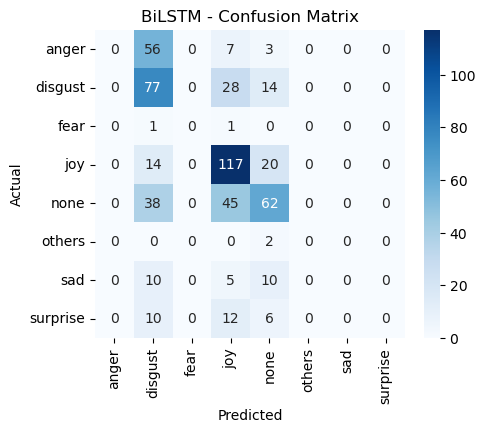

In [24]:
# BiLSTM Model

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model_bilstm = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    Bidirectional(LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3)),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_bilstm.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_bilstm = model_bilstm.fit(
    X_train_pad, y_train_cat,
    epochs=EPOCHS_DL,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop_emo, reduce_lr_emo],
    verbose=1
)

loss_bilstm, acc_bilstm = model_bilstm.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"\nBiLSTM Test Accuracy: {acc_bilstm:.4f}")

# Confusion Matrix
y_pred_bilstm = np.argmax(model_bilstm.predict(X_test_pad, verbose=0), axis=1)
cm_bilstm = confusion_matrix(y_test, y_pred_bilstm)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_bilstm, annot=True, fmt='d', cmap='Blues',
    xticklabels=le.classes_, yticklabels=le.classes_
)
plt.title("BiLSTM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 249ms/step - accuracy: 0.2696 - loss: 1.8015 - val_accuracy: 0.2715 - val_loss: 1.6429 - learning_rate: 0.0010
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.2667 - loss: 1.7064 - val_accuracy: 0.2715 - val_loss: 1.6190 - learning_rate: 0.0010
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 233ms/step - accuracy: 0.2841 - loss: 1.6877 - val_accuracy: 0.2715 - val_loss: 1.6262 - learning_rate: 3.0000e-04
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 6s 234ms/step - accuracy: 0.2743 - loss: 1.6946 - val_accuracy: 0.2715 - val_loss: 1.6195 - learning_rate: 3.0000e-04

Multi-layer LSTM Test Accuracy: 0.2807


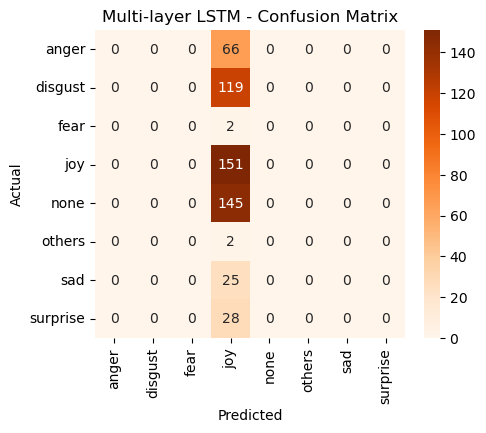

In [25]:
# LSTM Model 

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model_lstm_multi = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),

    # First LSTM layer (returns sequences to feed the next layer)
    LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),

    # Second LSTM layer (final)
    LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),

    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_lstm_multi.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_lstm_multi = model_lstm_multi.fit(
    X_train_pad, y_train_cat,
    epochs=EPOCHS_DL,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop_emo, reduce_lr_emo],
    verbose=1
)

loss_lstm_multi, acc_lstm_multi = model_lstm_multi.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"\nMulti-layer LSTM Test Accuracy: {acc_lstm_multi:.4f}")

# Confusion Matrix
y_pred_lstm_multi = np.argmax(model_lstm_multi.predict(X_test_pad, verbose=0), axis=1)
cm_lstm_multi = confusion_matrix(y_test, y_pred_lstm_multi)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_lstm_multi, annot=True, fmt='d', cmap='Oranges',
    xticklabels=le.classes_, yticklabels=le.classes_
)
plt.title("Multi-layer LSTM - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


Epoch 1/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - accuracy: 0.2446 - loss: 1.8090 - val_accuracy: 0.2715 - val_loss: 1.6361 - learning_rate: 0.0010
Epoch 2/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2714 - loss: 1.7034 - val_accuracy: 0.2715 - val_loss: 1.6329 - learning_rate: 0.0010
Epoch 3/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2777 - loss: 1.6842 - val_accuracy: 0.2715 - val_loss: 1.6228 - learning_rate: 3.0000e-04
Epoch 4/10
27/27 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - accuracy: 0.2667 - loss: 1.6780 - val_accuracy: 0.2715 - val_loss: 1.6229 - learning_rate: 3.0000e-04

Simple RNN Test Accuracy: 0.2807


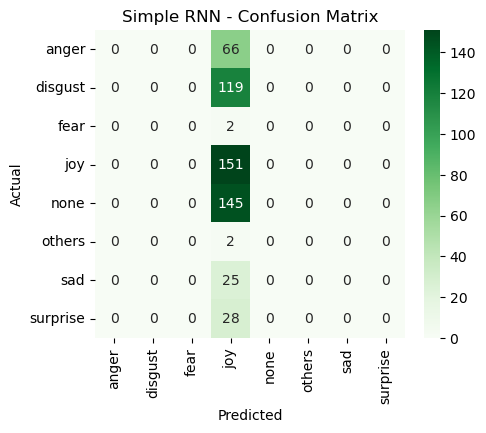

In [26]:
# Simple RNN Model 

tf.random.set_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

model_rnn = Sequential([
    Embedding(input_dim=MAX_VOCAB, output_dim=128, input_length=MAX_LEN),
    SimpleRNN(64, return_sequences=False, dropout=0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model_rnn.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

history_rnn = model_rnn.fit(
    X_train_pad, y_train_cat,
    epochs=EPOCHS_DL,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    callbacks=[early_stop_emo, reduce_lr_emo],
    verbose=1
)

loss_rnn, acc_rnn = model_rnn.evaluate(X_test_pad, y_test_cat, verbose=0)
print(f"\nSimple RNN Test Accuracy: {acc_rnn:.4f}")

# Confusion Matrix
y_pred_rnn = np.argmax(model_rnn.predict(X_test_pad, verbose=0), axis=1)
cm_rnn = confusion_matrix(y_test, y_pred_rnn)

plt.figure(figsize=(5,4))
sns.heatmap(
    cm_rnn, annot=True, fmt='d', cmap='Greens',
    xticklabels=le.classes_, yticklabels=le.classes_
)
plt.title("Simple RNN - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()


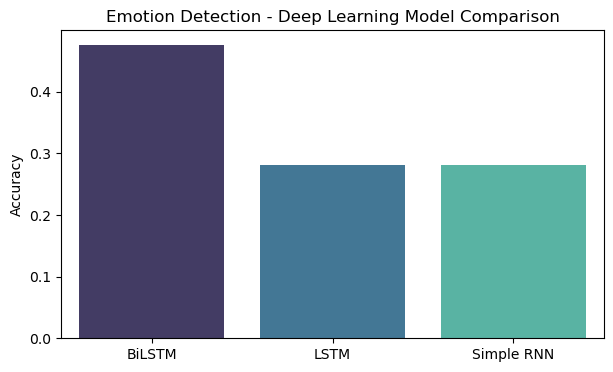

In [27]:
# Deep Learning Model Comparison

models_dl = ['BiLSTM', 'LSTM', 'Simple RNN']
acc_dl = [acc_bilstm, acc_lstm_multi, acc_rnn]

plt.figure(figsize=(7,4))
sns.barplot(x=models_dl, y=acc_dl, palette='mako')
plt.title('Emotion Detection - Deep Learning Model Comparison')
plt.ylabel('Accuracy')
plt.show()



🏁 Final Accuracy Summary:
                Model  Accuracy
0              BiLSTM  0.475836
1  LogisticRegression  0.460967
2         Naive Bayes  0.449814
3                 SVM  0.438662
4   PassiveAggressive  0.401487
5          Simple RNN  0.280669
6                LSTM  0.280669


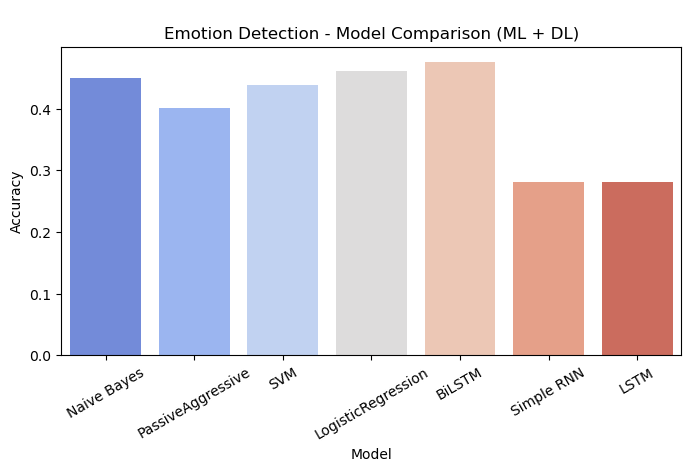

In [28]:
# Final MODEL PERFORMANCE COMPARISON

acc_all = {
    'Naive Bayes': accuracy_score(y_test, y_pred_nb),
    'PassiveAggressive': accuracy_score(y_test, y_pred_pac),
    'SVM': accuracy_score(y_test, y_pred_svm),
    'LogisticRegression': accuracy_score(y_test, y_pred_log),
    'BiLSTM': acc_bilstm,
    'Simple RNN': acc_rnn,
    'LSTM': acc_lstm_multi
}

acc_df = pd.DataFrame(list(acc_all.items()), columns=['Model', 'Accuracy'])

print("\n🏁 Final Accuracy Summary:")
print(acc_df.sort_values(by='Accuracy', ascending=False).reset_index(drop=True))

plt.figure(figsize=(8,4))
sns.barplot(x='Model', y='Accuracy', data=acc_df, palette='coolwarm')
plt.title('\nEmotion Detection - Model Comparison (ML + DL)')
plt.ylabel('Accuracy')
plt.xticks(rotation=30)
plt.show()

In [29]:
# 5-Fold Cross-Validation for all models 

from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

print("\n5-Fold Cross-Validation for all models (Emotion Classification)...\n")

SEED = 42
skf    = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
skf_dl = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)


# Helper functions 

def generalization_comment(train_acc, val_acc, test_acc, threshold=0.02):
    if train_acc > test_acc + threshold:
        return "Potential Overfitting: Training metrics significantly higher than test metrics."
    elif val_acc < 0.60 and test_acc < 0.60:
        return "Potential Underfitting: Model shows low validation and testing performance."
    else:
        return "The model seems to generalize well with balanced training and testing performance."


def print_model_summary_block(
    name,
    train_acc_mean, train_acc_std,
    train_prec, train_rec, train_f1,
    val_acc, val_prec, val_rec, val_f1,
    test_acc, test_prec, test_rec, test_f1
):
    print(f"\n=============== {name} ===============\n")

    print("Training Performance (5-Fold CV):")
    print(f"Accuracy:  {train_acc_mean:.4f} ± {train_acc_std:.4f}")
    print(f"Precision: {train_prec:.4f}")
    print(f"Recall:    {train_rec:.4f}")
    print(f"F1-score:  {train_f1:.4f}\n")

    print("Validation Performance (5-Fold CV):")
    print(f"Accuracy:  {val_acc:.4f}")
    print(f"Precision: {val_prec:.4f}")
    print(f"Recall:    {val_rec:.4f}")
    print(f"F1-score:  {val_f1:.4f}\n")

    print("Testing Performance:")
    print(f"Accuracy:  {test_acc:.4f}")
    print(f"Precision: {test_prec:.4f}")
    print(f"Recall:    {test_rec:.4f}")
    print(f"F1-score:  {test_f1:.4f}\n")

    comment = generalization_comment(train_acc_mean, val_acc, test_acc)
    print("", comment, "\n")


#  Classical ML Models (CV)

ml_models_emo = {
    "Logistic Regression": LogisticRegression(max_iter=300, random_state=SEED),
    "Naive Bayes":         MultinomialNB(),
    "Linear SVM":          LinearSVC(max_iter=10000, random_state=SEED),
    "Passive-Aggressive":  PassiveAggressiveClassifier(max_iter=1000, random_state=SEED)
}

for model_name, base_model in ml_models_emo.items():

    train_fold_accs = []
    val_fold_accs   = []

    y_train_all, y_train_pred_all = [], []
    y_val_all,   y_val_pred_all   = [], []

    # CV on TRAIN split
    for tr_idx, val_idx in skf.split(X_train_vec, y_train):
        X_tr, X_val = X_train_vec[tr_idx], X_train_vec[val_idx]
        y_tr, y_val = y_train[tr_idx],  y_train[val_idx]

        model = base_model.__class__(**base_model.get_params())
        model.fit(X_tr, y_tr)

        y_tr_pred  = model.predict(X_tr)
        y_val_pred = model.predict(X_val)

        train_fold_accs.append(accuracy_score(y_tr, y_tr_pred))
        val_fold_accs.append(accuracy_score(y_val, y_val_pred))

        y_train_all.extend(y_tr.tolist())
        y_train_pred_all.extend(y_tr_pred.tolist())
        y_val_all.extend(y_val.tolist())
        y_val_pred_all.extend(y_val_pred.tolist())

    # Aggregated training metrics
    train_acc_mean = np.mean(train_fold_accs)
    train_acc_std  = np.std(train_fold_accs)
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
        y_train_all, y_train_pred_all, average='weighted', zero_division=0
    )

    # Aggregated validation metrics
    val_acc = accuracy_score(y_val_all, y_val_pred_all)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
        y_val_all, y_val_pred_all, average='weighted', zero_division=0
    )

    # Final TEST evaluation
    final_model = base_model.__class__(**base_model.get_params())
    final_model.fit(X_train_vec, y_train)
    y_test_pred = final_model.predict(X_test_vec)

    test_acc = accuracy_score(y_test, y_test_pred)
    test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
        y_test, y_test_pred, average='weighted', zero_division=0
    )

    print_model_summary_block(
        model_name,
        train_acc_mean, train_acc_std,
        train_prec, train_rec, train_f1,
        val_acc, val_prec, val_rec, val_f1,
        test_acc, test_prec, test_rec, test_f1
    )


# Deep Learning Models (CV)

num_classes_emotion = num_classes  

def build_rnn_emo():
    m = Sequential([
        Embedding(MAX_VOCAB, 128, input_length=MAX_LEN),
        SimpleRNN(64, return_sequences=False, dropout=0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes_emotion, activation='softmax')
    ])
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return m

def build_bilstm_emo():
    m = Sequential([
        Embedding(MAX_VOCAB, 128, input_length=MAX_LEN),
        Bidirectional(LSTM(64, dropout=0.3, return_sequences=False)),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes_emotion, activation='softmax')
    ])
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return m

def build_lstm_multi_emo():
    m = Sequential([
        Embedding(MAX_VOCAB, 128, input_length=MAX_LEN),
        LSTM(128, return_sequences=True, dropout=0.3, recurrent_dropout=0.3),
        LSTM(64, return_sequences=False, dropout=0.3, recurrent_dropout=0.3),
        Dense(64, activation='relu'),
        Dropout(0.3),
        Dense(num_classes_emotion, activation='softmax')
    ])
    m.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return m


def cv_evaluate_dl_emotion(
    model_name,
    build_fn,
    trained_model,
    X_train_pad_arr, y_train_arr,
    X_test_pad_arr,  y_test_arr
):
    train_fold_accs = []
    val_fold_accs   = []

    y_tr_all, y_tr_pred_all   = [], []
    y_val_all, y_val_pred_all = [], []

    for tr_idx, val_idx in skf_dl.split(X_train_pad_arr, y_train_arr):
        X_tr, X_val = X_train_pad_arr[tr_idx], X_train_pad_arr[val_idx]
        y_tr, y_val = y_train_arr[tr_idx],  y_train_arr[val_idx]

        y_tr_cat  = to_categorical(y_tr,  num_classes=num_classes_emotion)
        y_val_cat = to_categorical(y_val, num_classes=num_classes_emotion)

        m = build_fn()
        m.fit(
            X_tr, y_tr_cat,
            epochs=EPOCHS_DL,
            batch_size=BATCH_SIZE,
            validation_data=(X_val, y_val_cat),
            callbacks=[early_stop_emo, reduce_lr_emo],
            verbose=0
        )

        train_pred = np.argmax(m.predict(X_tr,  verbose=0), axis=1)
        val_pred   = np.argmax(m.predict(X_val, verbose=0), axis=1)

        train_fold_accs.append(accuracy_score(y_tr, train_pred))
        val_fold_accs.append(accuracy_score(y_val, val_pred))

        y_tr_all.extend(y_tr.tolist())
        y_tr_pred_all.extend(train_pred.tolist())
        y_val_all.extend(y_val.tolist())
        y_val_pred_all.extend(val_pred.tolist())

    # Aggregated training metrics
    train_acc_mean = np.mean(train_fold_accs)
    train_acc_std  = np.std(train_fold_accs)
    train_prec, train_rec, train_f1, _ = precision_recall_fscore_support(
        y_tr_all, y_tr_pred_all, average='weighted', zero_division=0
    )

    # Aggregated validation metrics
    val_acc = accuracy_score(y_val_all, y_val_pred_all)
    val_prec, val_rec, val_f1, _ = precision_recall_fscore_support(
        y_val_all, y_val_pred_all, average='weighted', zero_division=0
    )

    # Test metrics from the already-trained full model
    test_probs = trained_model.predict(X_test_pad_arr, verbose=0)
    test_pred  = np.argmax(test_probs, axis=1)

    test_acc = accuracy_score(y_test_arr, test_pred)
    test_prec, test_rec, test_f1, _ = precision_recall_fscore_support(
        y_test_arr, test_pred, average='weighted', zero_division=0
    )

    print_model_summary_block(
        model_name,
        train_acc_mean, train_acc_std,
        train_prec, train_rec, train_f1,
        val_acc, val_prec, val_rec, val_f1,
        test_acc, test_prec, test_rec, test_f1
    )


# Use the models you already trained above:
cv_evaluate_dl_emotion(
    "Simple RNN",
    build_rnn_emo,
    model_rnn,
    X_train_pad, y_train,
    X_test_pad,  y_test
)

cv_evaluate_dl_emotion(
    "BiLSTM",
    build_bilstm_emo,
    model_bilstm,
    X_train_pad, y_train,
    X_test_pad,  y_test
)

cv_evaluate_dl_emotion(
    "Multi-layer LSTM",
    build_lstm_multi_emo,
    model_lstm_multi,
    X_train_pad, y_train,
    X_test_pad,  y_test
)



5-Fold Cross-Validation for all models (Emotion Classification)...


=============== Logistic Regression ===============

Training Performance (5-Fold CV):
Accuracy:  0.7831 ± 0.0030
Precision: 0.8081
Recall:    0.7831
F1-score:  0.7369

Validation Performance (5-Fold CV):
Accuracy:  0.4545
Precision: 0.3864
Recall:    0.4545
F1-score:  0.4057

Testing Performance:
Accuracy:  0.4610
Precision: 0.3927
Recall:    0.4610
F1-score:  0.4166

 Potential Overfitting: Training metrics significantly higher than test metrics. 


=============== Naive Bayes ===============

Training Performance (5-Fold CV):
Accuracy:  0.7470 ± 0.0056
Precision: 0.6931
Recall:    0.7470
F1-score:  0.6912

Validation Performance (5-Fold CV):
Accuracy:  0.4493
Precision: 0.3826
Recall:    0.4493
F1-score:  0.3892

Testing Performance:
Accuracy:  0.4498
Precision: 0.4041
Recall:    0.4498
F1-score:  0.3937

 Potential Overfitting: Training metrics significantly higher than test metrics. 


=============== Linear SVM